# Data Vizulaization

# Load in Data

In [4]:
#read in file as dataframe 
# import pyspark modules
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *       # for datatype conversion
from pyspark.sql.functions import *   # for col() function
import pandas as pd
import os
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, Row
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import SparseVector, DenseVector
import functools 
import matplotlib as plt
import warnings
warnings.filterwarnings('ignore')


In [5]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50

%matplotlib inline
import matplotlib.pyplot as plt


In [6]:
from pyspark.sql import SparkSession 
spark = SparkSession \
    .builder \
    .master("local") \
    .appName("app") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '2') \
    .config("spark.driver.memory",'4g') \
    .getOrCreate()

sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

In [7]:
path_to_data = os.path.join("/home/jovyan/FlightDelay/clean_data_no_hot")

In [8]:
df = spark.read.format("csv") \
    .option("header", "true").option("inferschema","true").load(path_to_data)

In [9]:
df2 = df.sample(False, 0.2, 444)
pd_df = df2.toPandas()

In [10]:
pd_df.head()

,_c0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,B_SCHEDULED_ARRIVAL,B_ARRIVAL_TIME,B_SCHEDULED_DEPARTURE,B_DEPARTURE_TIME
0,0,2015,1,1,4,AA,2459,PHX,DFW,200,1336,9,120,137,868,500,1476,4,0,1,1.0,4.0,0.0,4.0
1,2,2015,1,1,4,DL,1890,DFW,ATL,545,603,18,124,104,731,849,847,-2,0,0,2.0,2.0,1.0,2.0
2,8,2015,1,1,4,F9,1104,CLE,FLL,600,556,-4,175,157,1062,855,833,-22,0,0,2.0,2.0,2.0,1.0
3,9,2015,1,1,4,MQ,3611,CAE,DFW,600,1336,9,185,137,922,805,1476,4,0,1,2.0,4.0,2.0,4.0
4,15,2015,1,1,4,AA,1595,AUS,DFW,650,647,-3,65,53,190,755,740,-15,0,0,2.0,2.0,2.0,2.0


In [12]:
# Create view so we can query using SQL
#df.createOrReplaceTempView("df_v")

#df2 = sqlCtx.sql("SELECT AIRLINE, CANCELLED from df_v") 

airlines_names = pd.read_csv('/home/jovyan/FlightDelay/airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [15]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

global_stats = pd_df['DEPARTURE_DELAY'].groupby(pd_df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,min
AIRLINE,,,,
VX,208.0,90.0,2.836538,-18.0
HA,259.0,59.0,-0.625483,-20.0
F9,328.0,87.0,4.649390,-21.0
NK,387.0,91.0,6.527132,-27.0
AS,568.0,86.0,-0.047535,-34.0
US,760.0,96.0,1.971053,-21.0
B6,909.0,98.0,4.336634,-22.0
MQ,993.0,88.0,4.584089,-36.0
UA,1754.0,101.0,7.653934,-20.0


In [16]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [17]:
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = pd_df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)

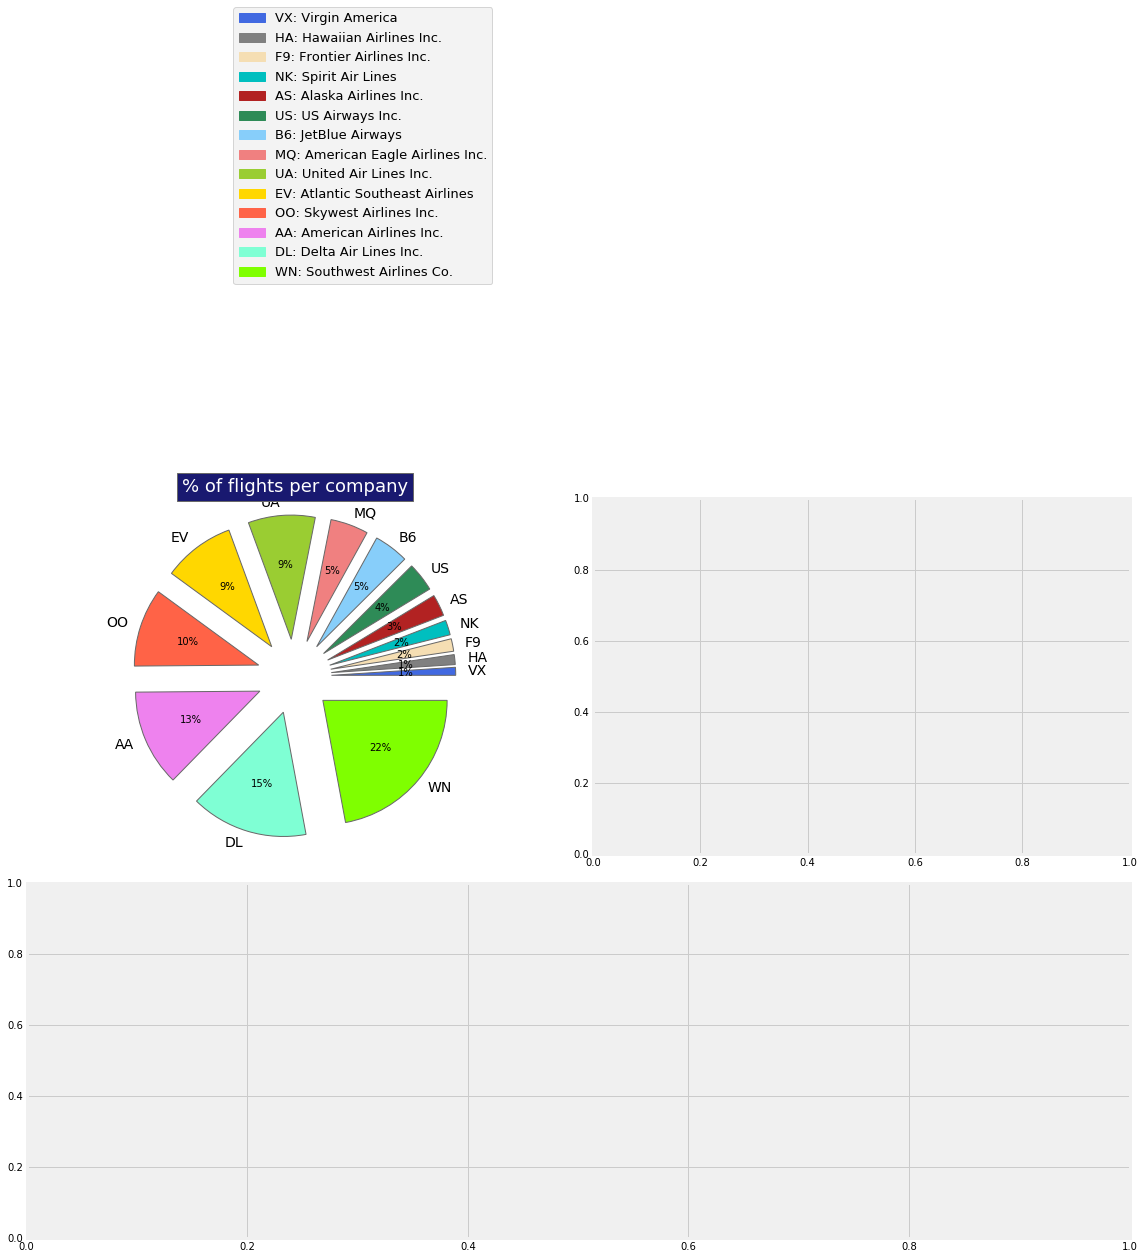

In [18]:
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)

#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)


plt.tight_layout(w_pad = 1)

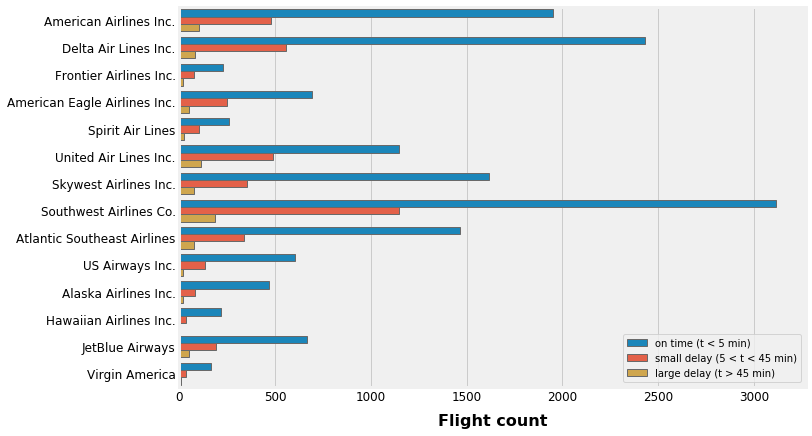

In [17]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
pd_df['DELAY_LEVEL'] = pd_df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=pd_df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

Text(0.5,1,'DELAYS')

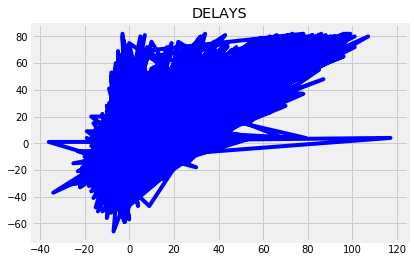

In [18]:
# Plot in blue the % of degrees awarded to women in the Physical Sciences
plt.plot(pd_df['DEPARTURE_DELAY'], pd_df['ARRIVAL_DELAY'], color='blue')
plt.title('DELAYS')

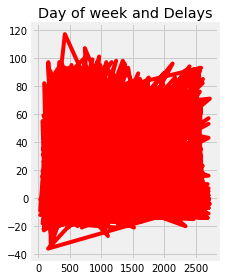

In [19]:
# Make the right subplot active in the current 1x2 subplot grid
plt.subplot(1, 2, 2)

# Plot in red the % of degrees awarded to women in Computer Science
plt.plot(pd_df['DISTANCE'], pd_df['DEPARTURE_DELAY'], color='red')
plt.title('Day of week and Delays')

# Use plt.tight_layout() to improve the spacing between subplots
plt.tight_layout()
plt.show()